# DEMO: Vectorized & Cached Scoring

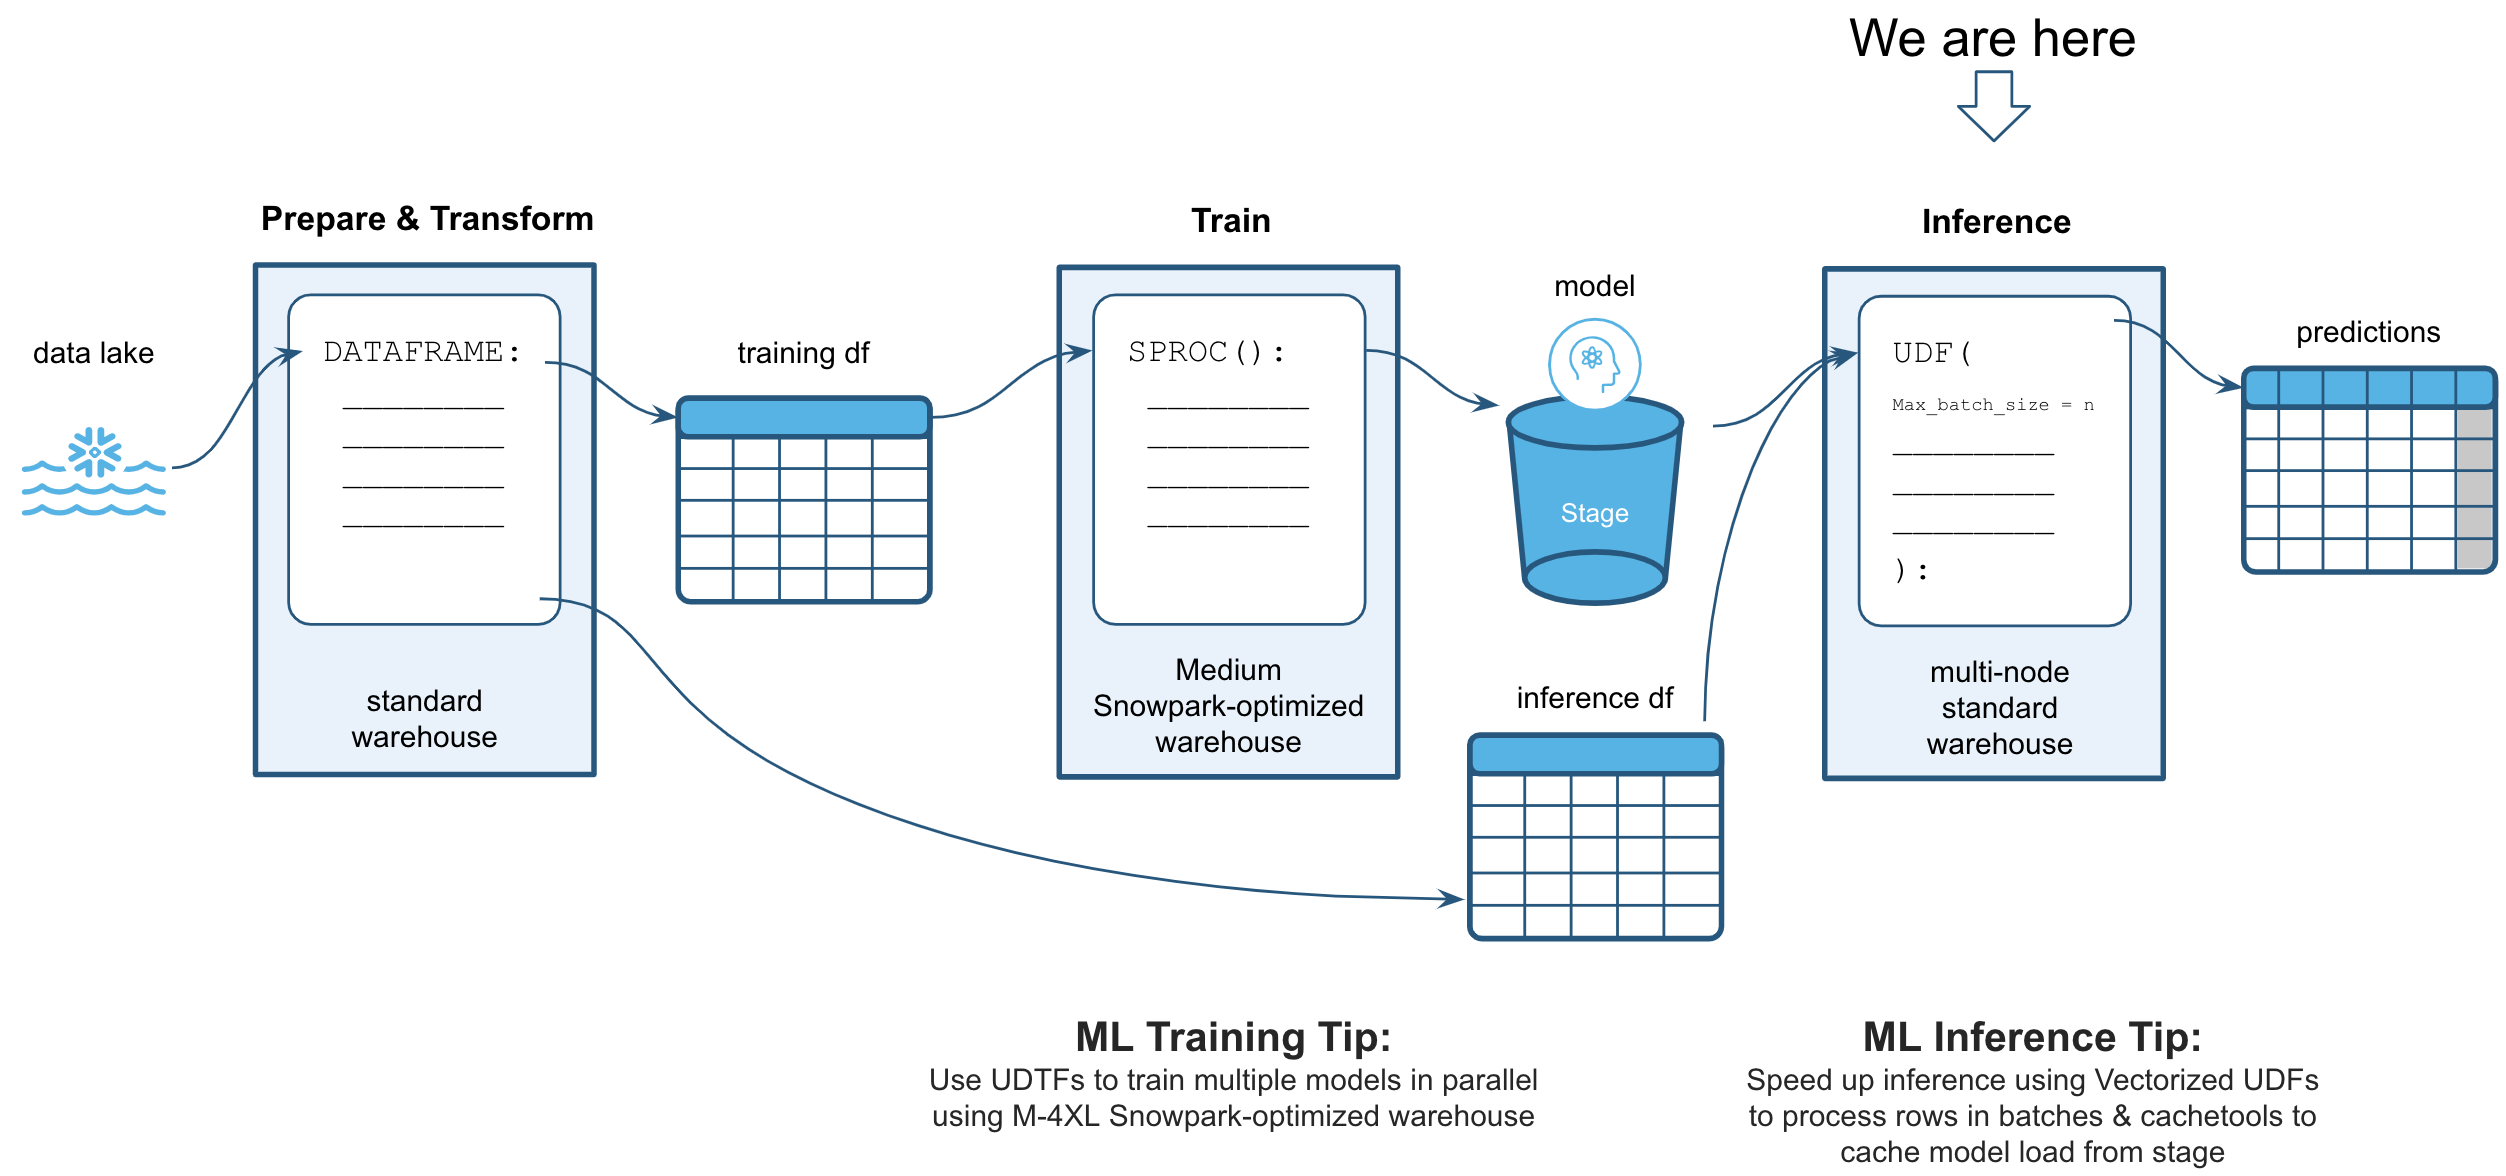

## Imports

In [ ]:
from snowflake.snowpark.session import Session
import snowflake.snowpark.functions as F
import snowflake.snowpark.types as T
from snowflake.snowpark.window import Window
import preprocessing

import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Create Snowpark Session

In [ ]:
with open('creds.json') as f:
    connection_parameters = json.load(f)

In [ ]:
session = Session.builder.configs(connection_parameters).create()
print(f"Current Database and schema: {session.get_fully_qualified_current_schema()}")
print(f"Current Warehouse: {session.get_current_warehouse()}")

In [ ]:
sk_version = "1.2.2"
snowpark_version = "1.3.0"
pandas_version = "1.5.3"

# Model Scoring (Vectorized)

In [ ]:
# Lets disable result-cache for a moment to see true scoring-performance
session.sql('ALTER SESSION SET USE_CACHED_RESULT = FALSE').collect() # disable caching so we are not cheating

In [ ]:
test_sdf = session.table('CREDIT_RISK_PREPARED_BALANCED_TEST')
feature_cols = test_sdf.columns
feature_cols.remove('TARGET')
feature_cols.remove('ID')
target_col = 'TARGET'

In [ ]:
session.sql("ls @ML_MODELS").show()

In [ ]:
# Define a simple scoring function which is vectorized
def udf_score_logistic_reg_model_vectorized(df: pd.DataFrame) -> pd.Series:
    import os
    import sys
    from joblib import load
    # file-dependencies of UDFs are available in snowflake_import_directory
    IMPORT_DIRECTORY_NAME = "snowflake_import_directory"
    import_dir = sys._xoptions[IMPORT_DIRECTORY_NAME]
    model_name = 'logistic_reg_model.sav'
    model = load(import_dir+model_name)
    df.columns = feature_cols
    scored_data = pd.Series(model.predict(df))
    return scored_data

In [ ]:
# Register Vectorized UDF
udf_score_logistic_reg_model_vectorized = session.udf.register(func=udf_score_logistic_reg_model_vectorized, 
                                                               name="udf_score_logistic_reg_model_vectorized", 
                                                               stage_location='@ML_MODELS',
                                                               input_types=[T.FloatType()]*len(feature_cols),
                                                               return_type = T.FloatType(),
                                                               replace=True, 
                                                               is_permanent=True, 
                                                               imports=['@ML_MODELS/logistic_reg_model.sav'],
                                                               packages=[f'scikit-learn=={sk_version}',f'pandas=={pandas_version}','joblib==1.1.1'], 
                                                               max_batch_size=1000,
                                                               session=session)

In [ ]:
%%time
# Scoring test data with vectorized UDF
scored_sdf = test_sdf.with_column('PREDICTION', udf_score_logistic_reg_model_vectorized(*feature_cols))
scored_sdf.write.save_as_table(table_name='CREDIT_RISK_PREPARED_BALANCED_TRAIN_SCORED', mode='overwrite')

# Model Scoring (Cached)

In [ ]:
# Define a simple scoring function
from cachetools import cached

@cached(cache={})
def load_model(model_path: str) -> object:
    from joblib import load
    model = load(model_path)
    return model

def udf_score_logistic_reg_model_cached(*args) -> float:
    import os
    import sys
    # file-dependencies of UDFs are available in snowflake_import_directory
    IMPORT_DIRECTORY_NAME = "snowflake_import_directory"
    import_dir = sys._xoptions[IMPORT_DIRECTORY_NAME]
    model_name = 'logistic_reg_model.sav'
    model = load_model(import_dir+model_name)
    scored_data = model.predict(pd.DataFrame([args]))[0]
    return scored_data

In [ ]:
# Register UDF
udf_score_logistic_reg_model_cached = session.udf.register(func=udf_score_logistic_reg_model_cached, 
                                                           name="udf_score_logistic_reg_model_cached", 
                                                           stage_location='@ML_MODELS',
                                                           input_types=[T.FloatType()]*len(feature_cols),
                                                           return_type = T.FloatType(),
                                                           replace=True, 
                                                           is_permanent=True, 
                                                           imports=['@ML_MODELS/logistic_reg_model.sav'],
                                                           packages=[f'scikit-learn=={sk_version}',f'pandas=={pandas_version}','joblib==1.1.1', 'cachetools==4.2.2'], 
                                                           session=session)

In [ ]:
%%time
# Scoring test data with scalar UDF but caching the model
scored_sdf = test_sdf.with_column('PREDICTION', udf_score_logistic_reg_model_cached(*feature_cols))
scored_sdf.write.save_as_table(table_name='CREDIT_RISK_PREPARED_BALANCED_TRAIN_SCORED', mode='overwrite')

# Model Scoring (Vectorized & Cached)

In [ ]:
# Define a simple scoring function
from cachetools import cached

@cached(cache={})
def load_model(model_path: str) -> object:
    from joblib import load
    model = load(model_path)
    return model

def udf_score_logistic_reg_model_vec_cached(df: pd.DataFrame) -> pd.Series:
    import os
    import sys
    # file-dependencies of UDFs are available in snowflake_import_directory
    IMPORT_DIRECTORY_NAME = "snowflake_import_directory"
    import_dir = sys._xoptions[IMPORT_DIRECTORY_NAME]
    model_name = 'logistic_reg_model.sav'
    model = load_model(import_dir+model_name)
    df.columns = feature_cols
    scored_data = pd.Series(model.predict(df))
    return scored_data

In [ ]:
# Register Vectorized UDF
udf_score_logistic_reg_model_vec_cached = session.udf.register(func=udf_score_logistic_reg_model_vec_cached, 
                                                               name="udf_score_logistic_reg_model_vec_cached", 
                                                               stage_location='@ML_MODELS',
                                                               input_types=[T.FloatType()]*len(feature_cols),
                                                               return_type = T.FloatType(),
                                                               replace=True, 
                                                               is_permanent=True, 
                                                               imports=['@ML_MODELS/logistic_reg_model.sav'],
                                                               packages=[f'scikit-learn=={sk_version}',f'pandas=={pandas_version}','joblib==1.1.1', 'cachetools==4.2.2'], 
                                                               max_batch_size=1000,
                                                               session=session)

In [ ]:
%%time
# Scoring test data with scalar UDF but caching the model
scored_sdf = test_sdf.with_column('PREDICTION', udf_score_logistic_reg_model_vec_cached(*feature_cols))
scored_sdf.write.save_as_table(table_name='CREDIT_RISK_PREPARED_BALANCED_TRAIN_SCORED', mode='overwrite')

In [ ]:
# Lets re-enable result-cache
session.sql('ALTER SESSION SET USE_CACHED_RESULT = TRUE').collect()

In [ ]:
session.close()